In [2]:
%pip install ucimlrepo pyAgrum 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder


In [4]:
# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

# metadata
print(student_performance.metadata)

# variable information
print(student_performance.variables)

{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

In [5]:
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,4
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,6
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,0


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [7]:
X.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
dtype: int64

In [8]:
y.head()

,G1,G2,G3
0,0,11,11
1,9,11,11
2,12,13,12
3,14,14,14
4,11,13,13


Создаем новый таргет FinalPass на основе G3: 1 — сдал, 0 — не сдал.
По распределению видно: 549 успешных (≈84.6%) и 100 неуспешных (≈15.4%).

In [9]:
# Берём финальную оценку
g3 = y['G3']

# Новый таргет: 1 = сдал предмет (>=10), 0 = не сдал
FinalPass = (g3 >= 10).astype(int)

# Смотрим распределение
FinalPass.value_counts(), FinalPass.value_counts(normalize=True)

(G3
 1    549
 0    100
 Name: count, dtype: int64,
 G3
 1    0.845917
 0    0.154083
 Name: proportion, dtype: float64)

In [11]:
FinalPass.sample(10)

416    1
627    1
235    1
302    1
598    1
589    1
169    1
638    1
582    0
149    1
Name: G3, dtype: int64

Собраем новый набор признаков для сети: оценки (G1, G2), учебные и поведенческие характеристики (studytime, absences, goout, Dalc, Walc), здоровье и поддержка.

In [14]:
# --- Блок 2 ---
# Выбираем новый набор признаков для сети
# (берём G1 и G2 из y, остальное — из X)

features = pd.DataFrame({
    "G1": y["G1"],
    "G2": y["G2"],
    "studytime": X["studytime"],
    "absences": X["absences"],
    "goout": X["goout"],
    "Dalc": X["Dalc"],
    "Walc": X["Walc"],
    "health": X["health"],
    "famsup": X["famsup"],
    "schoolsup": X["schoolsup"]
})

features.head()


,G1,G2,studytime,absences,goout,Dalc,Walc,health,famsup,schoolsup
0,0,11,2,4,4,1,1,3,no,yes
1,9,11,2,2,3,1,1,3,yes,no
2,12,13,2,6,2,2,3,3,no,yes
3,14,14,3,0,2,1,1,5,yes,no
4,11,13,2,0,2,1,2,5,yes,no


In [16]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   G1         649 non-null    int64 
 1   G2         649 non-null    int64 
 2   studytime  649 non-null    int64 
 3   absences   649 non-null    int64 
 4   goout      649 non-null    int64 
 5   Dalc       649 non-null    int64 
 6   Walc       649 non-null    int64 
 7   health     649 non-null    int64 
 8   famsup     649 non-null    object
 9   schoolsup  649 non-null    object
dtypes: int64(8), object(2)
memory usage: 50.8+ KB


In [ ]:
['famsup'].unique()

array(['no', 'yes'], dtype=object)

In [17]:
# Дискретизация выбранных признаков
disc = features.copy()

disc["G1_cat"] = pd.cut(disc["G1"], bins=[-1, 9, 14, 20],
                        labels=["low", "mid", "high"])
disc["G2_cat"] = pd.cut(disc["G2"], bins=[-1, 9, 14, 20],
                        labels=["low", "mid", "high"])

disc["abs_cat"] = pd.cut(disc["absences"], bins=[-1, 2, 7, 100],
                         labels=["low", "mid", "high"])

disc["famsup_cat"] = disc["famsup"].map({"no": 0, "yes": 1})
disc["schoolsup_cat"] = disc["schoolsup"].map({"no": 0, "yes": 1})

disc[["G1_cat", "G2_cat", "abs_cat", "famsup_cat", "schoolsup_cat"]].head()


,G1_cat,G2_cat,abs_cat,famsup_cat,schoolsup_cat
0,low,mid,mid,0,1
1,low,mid,low,1,0
2,mid,mid,mid,0,1
3,mid,mid,low,1,0
4,mid,mid,low,1,0


In [18]:
# Формируем итоговый датафрейм для обучения Байесовской сети
# Используем дискретизированные признаки и новый таргет FinalPass

bn_data = pd.DataFrame({
    "G1_cat": disc["G1_cat"].astype(str),
    "G2_cat": disc["G2_cat"].astype(str),
    "abs_cat": disc["abs_cat"].astype(str),
    "studytime": disc["studytime"].astype(str),
    "goout": disc["goout"].astype(str),
    "Dalc": disc["Dalc"].astype(str),
    "Walc": disc["Walc"].astype(str),
    "health": disc["health"].astype(str),
    "famsup_cat": disc["famsup_cat"].astype(str),
    "schoolsup_cat": disc["schoolsup_cat"].astype(str),
    "FinalPass": FinalPass.astype(str)
})

bn_data.head()


,G1_cat,G2_cat,abs_cat,studytime,goout,Dalc,Walc,health,famsup_cat,schoolsup_cat,FinalPass
0,low,mid,mid,2,4,1,1,3,0,1,1
1,low,mid,low,2,3,1,1,3,1,0,1
2,mid,mid,mid,2,2,2,3,3,0,1,1
3,mid,mid,low,3,2,1,1,5,1,0,1
4,mid,mid,low,2,2,1,2,5,1,0,1


Nodes in DAG: {'studytime', 'abs_cat', 'Dalc', 'G2_cat', 'Walc', 'FinalPass', 'famsup_cat', 'goout', 'health', 'G1_cat', 'schoolsup_cat'}
Arcs in DAG: {(0, 1), (9, 3), (2, 10), (5, 4), (6, 4), (4, 2), (3, 0), (8, 3), (1, 10), (7, 2)}


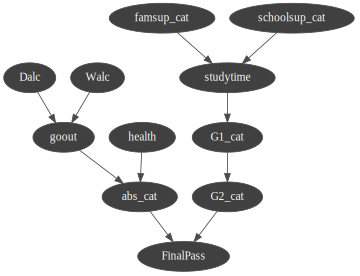

In [21]:
# --- Новый Блок DAG (замена старого построения сети) ---

bn = gum.BayesNet('StudentPerformance_New')

# Определяем мощности категорий по нашему bn_data
card = {c: int(bn_data[c].nunique()) for c in bn_data.columns}

# Создаём узлы
for var in bn_data.columns:
    lv = gum.LabelizedVariable(var, var, card[var])
    bn.add(lv)

# Добавляем новые логические дуги (совершенно другая структура)
arcs = [
    # Академическая цепочка
    ("studytime", "G1_cat"),
    ("G1_cat", "G2_cat"),
    ("G2_cat", "FinalPass"),

    # Прогулы как фактор риска
    ("goout", "abs_cat"),
    ("health", "abs_cat"),
    ("abs_cat", "FinalPass"),

    # Алкоголь → социализация
    ("Dalc", "goout"),
    ("Walc", "goout"),

    # Поддержка семьи/школы → учебное время
    ("famsup_cat", "studytime"),
    ("schoolsup_cat", "studytime"),
]

# Добавляем дуги
for u, v in arcs:
    bn.addArc(u, v)

print("Nodes in DAG:", bn.names())
print("Arcs in DAG:", bn.arcs())

# Визуализация сети
gnb.showBN(bn)


In [24]:
# --- Финальный универсальный блок подготовки bn_data для pyAgrum ---

from sklearn.preprocessing import LabelEncoder

bn_data = disc.copy()
bn_data["FinalPass"] = FinalPass

# Преобразуем ВСЁ к строкам (включая категории)
for col in bn_data.columns:
    bn_data[col] = bn_data[col].astype(str)

# Кодируем каждую колонку своим LabelEncoder
for col in bn_data.columns:
    le = LabelEncoder()
    bn_data[col] = le.fit_transform(bn_data[col])

# Гарантируем, что всё числовое
bn_data = bn_data.astype(int)

bn_data.head()


,G1,G2,studytime,absences,goout,Dalc,Walc,health,famsup,schoolsup,G1_cat,G2_cat,abs_cat,famsup_cat,schoolsup_cat,FinalPass
0,0,2,1,18,3,0,0,2,0,1,1,2,2,0,1,1
1,16,2,1,10,2,0,0,2,1,0,1,2,1,1,0,1
2,3,4,1,20,1,1,2,2,0,1,2,2,2,0,1,1
3,5,5,2,0,1,0,0,4,1,0,2,2,1,1,0,1
4,2,4,1,0,1,0,1,4,1,0,2,2,1,1,0,1


In [25]:
learner = gum.BNLearner(bn_data, bn)
learner.useSmoothingPrior(1)
params = learner.learnParameters(bn.dag())


In [26]:
# Вывод таблиц вероятностей для всех узлов новой сети
for node in params.names():
    print(f"CPD of {node}:\n{params.cpt(node)}\n")


CPD of studytime:

             ||  studytime                            |
famsup|school||0        |1        |2        |3        |
------|------||---------|---------|---------|---------|
0     |0     || 0.4407  | 0.3898  | 0.1314  | 0.0381  |
1     |0     || 0.2776  | 0.4958  | 0.1643  | 0.0623  |
0     |1     || 0.1304  | 0.6522  | 0.1304  | 0.0870  |
1     |1     || 0.2075  | 0.5094  | 0.1698  | 0.1132  |


CPD of abs_cat:

             ||  abs_cat                    |
goout |health||0        |1        |2        |
------|------||---------|---------|---------|
0     |0     || 0.1250  | 0.5000  | 0.3750  |
1     |0     || 0.2381  | 0.5238  | 0.2381  |
2     |0     || 0.1852  | 0.5556  | 0.2593  |
3     |0     || 0.2581  | 0.4516  | 0.2903  |
4     |0     || 0.3889  | 0.3333  | 0.2778  |
0     |1     || 0.2000  | 0.5000  | 0.3000  |
[...13 more line(s) ...]
4     |3     || 0.2222  | 0.5000  | 0.2778  |
0     |4     || 0.2174  | 0.5217  | 0.2609  |
1     |4     || 0.2000  | 0.5538  | 0.2

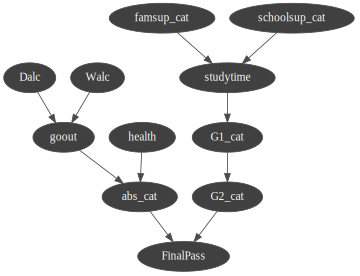

In [27]:
gnb.showBN(bn)

### Сценарии инференса

Выполняем три сценария инференса для новой Байесовской сети.  
Каждый сценарий комбинирует несколько причинных факторов из разных веток диаграммы:

1. **Сценарий академического успеха** – высокие оценки, мало пропусков, хорошее здоровье и минимальный алкоголь.  
   Ожидается высокая вероятность `FinalPass`.

2. **Рисковый социальный профиль** – частые прогулки, употребление алкоголя, низкое время на учёбу и большое количество пропусков.  
   Вероятность `FinalPass` снижается.

3. **Противоречивый случай** – высокая семейная и школьная поддержка, но низкие оценки и слабое здоровье.  
   Результат должен быть смешанным, что отражает конкуренцию факторов.

Эти сценарии демонстрируют работу сети при разных наборах причин и позволяют оценить вклад учебных, социальных и поведенческих переменных в итоговую вероятность успешного прохождения курса.


In [31]:
# --- Новый Блок (расширенные сложные сценарии инференса) ---

ie = gum.LazyPropagation(params)

# 3 сложных сценария, каждый включает несколько факторов

evidences = [
    # 1) Сильная академическая подготовка + хорошее здоровье + низкое влияние алкоголя
    {
        "G1_cat": 2,          # высокая оценка в 1 период
        "G2_cat": 2,          # высокая оценка во 2 период
        "health": 4,          # хорошее здоровье
        "abs_cat": 0,         # мало пропусков
        "Dalc": 0,            # не пьёт по будням
        "Walc": 1             # почти не пьёт по выходным
    },

    # 2) Социальный риск-профиль: много гуляет, пьёт, слабая учебная вовлечённость
    {
        "goout": 4,           # часто гуляет
        "Walc": 4,            # пьёт по выходным
        "Dalc": 3,            # пьёт по будням
        "studytime": 1,       # мало учится
        "abs_cat": 2          # много пропусков
    },

    # 3) Противоречивый сценарий: высокая семейная поддержка,
    #    но низкие оценки и слабое здоровье
    {
        "famsup_cat": 1,      # есть семейная поддержка
        "schoolsup_cat": 1,   # есть школьная поддержка
        "health": 1,          # плохое здоровье
        "G2_cat": 0,          # низкая промежуточная оценка
        "abs_cat": 1          # среднее число пропусков
    }
]

for evidence in evidences:
    ie.setEvidence(evidence)
    ie.makeInference()
    print(f"Posterior of FinalPass with evidence: {evidence}")
    print(ie.posterior("FinalPass"))
    print("--------------------------------------\n")


Posterior of FinalPass with evidence: {'G1_cat': 2, 'G2_cat': 2, 'health': 4, 'abs_cat': 0, 'Dalc': 0, 'Walc': 1}

  FinalPass        |
0        |1        |
---------|---------|
 0.0429  | 0.9571  |

--------------------------------------

Posterior of FinalPass with evidence: {'goout': 4, 'Walc': 4, 'Dalc': 3, 'studytime': 1, 'abs_cat': 2}

  FinalPass        |
0        |1        |
---------|---------|
 0.1384  | 0.8616  |

--------------------------------------

Posterior of FinalPass with evidence: {'famsup_cat': 1, 'schoolsup_cat': 1, 'health': 1, 'G2_cat': 0, 'abs_cat': 1}

  FinalPass        |
0        |1        |
---------|---------|
 0.0145  | 0.9855  |

--------------------------------------

